<a href="https://colab.research.google.com/github/raj245rohit/Image_caption_generator/blob/main/Image_Caption_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import dataset from kaggle
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

 98% 1.02G/1.04G [00:04<00:00, 249MB/s]
100% 1.04G/1.04G [00:04<00:00, 232MB/s]


In [ ]:
!unzip flickr8k.zip

In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.utils import load_img, img_to_array, pad_sequences, to_categorical, plot_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

## Extract Image features

In [ ]:
#load vgg16 model
model = VGG16()
#restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
#summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#Extract features from image
features = {}

for img_name in tqdm(os.listdir('/content/Images')):
  #load image from file
  img_path = '/content/Images/' + img_name
  image = load_img(img_path, target_size=(224,224))
  #convert image pixels to numpy array
  image= img_to_array(image)
  #reshape data for model
  image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
  #preprocess image for vgg
  image = preprocess_input(image)
  #extract features
  feature = model.predict(image, verbose=0)
  #get image ID
  image_id = img_name.split('.')[0]
  #store feature
  features[image_id] = feature


  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
#store features in pickle
pickle.dump(features, open('/content/features.pkl', 'wb'))

In [ ]:
#load features from pickle
with open('/content/features.pkl','rb') as f:
  features = pickle.load(f)

##Load th captions data

In [ ]:
with open('/content/captions.txt', 'r') as f:
  next(f)
  captions_doc = f.read()

In [ ]:
#create mapping of image to captions
mapping = {}
#process lines
for line in tqdm(captions_doc.split('\n')):
  #split the line by comma
  token = line.split(',')
  if len(line) < 2:
    continue
  image_id, caption = token[0], token[1]
  #remove extention from image_id
  image_id = image_id.split('.')[0]
  # create list if multiple captions are there for same image_id
  if image_id not in mapping:
    mapping[image_id] = []
  mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

Preprocessing captions

In [ ]:
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      caption = captions[i]
      #preprocessing steps
      caption = caption.lower()
      #delete digits, special chars, etc
      caption = caption.replace('[^A-Za-z]', '')
      #delete additional spaces
      caption = caption.replace('\s+',' ')
      #add start and end tags to the caption
      caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
      captions[i] = caption



In [ ]:
mapping['1020651753_06077ec457']

['<start> black and white dog jumping in the air to get toy <end>',
 '<start> black and white dog jumps up towards yellow toy <end>',
 '<start> dog leaps to catch ball in field <end>',
 '<start> white dog is trying to catch ball in midair over grassy field <end>',
 '<start> the white dog is playing in green field with yellow toy <end>']

In [ ]:
clean(mapping)

In [ ]:
mapping['1020651753_06077ec457']

['startseq <start> black and white dog jumping in the air to get toy <end> endseq',
 'startseq <start> black and white dog jumps up towards yellow toy <end> endseq',
 'startseq <start> dog leaps to catch ball in field <end> endseq',
 'startseq <start> white dog is trying to catch ball in midair over grassy field <end> endseq',
 'startseq <start> the white dog is playing in green field with yellow toy <end> endseq']

In [ ]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [ ]:
len(all_captions)

40455

Tokenize the text

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index)+1

In [ ]:
vocab_size

8313

In [ ]:
#get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

33

Train Test Split

In [ ]:
image_ids = list(mapping.keys())
from sklearn.model_selection import train_test_split
train, test = train_test_split(image_ids, test_size=0.2, random_state=42)

In [ ]:
print(len(image_ids))
print(len(train))
print(len(test))

8091
6472
1619


Create data generator

In [ ]:
def data_generator(data_keys,mappig, features, tokenizer, max_length, vocab_size, batch_size):
  X1, X2, y = list(), list(), list()
  n = 0
  while 1:
    for key in data_keys:
      n += 1
      captions = mapping[key]
      #process each caption
      for caption in captions:
        #encode the sequence
        seq = tokenizer.texts_to_sequences([caption])[0]
        #split the sequence intoX, y pairs
        in_seq, out_seq = seq[:i], seq[i]
        #pad input sequence
        in_seq = pad_sequences([in_seq], maxlen= max_length)[0]
        #encode output sequence
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

        #store the sequences
        X1.append(features[key][0])
        X2.append(in_seq)
        y.append(out_seq)
      
    if n == batch_size:
      X1,X2,y = np.array(X1), np.array(X2), np.array(y)
      yield [X1, X2], y
      X1, X2, y = list(), list(), list()
      n=0


Model Creation

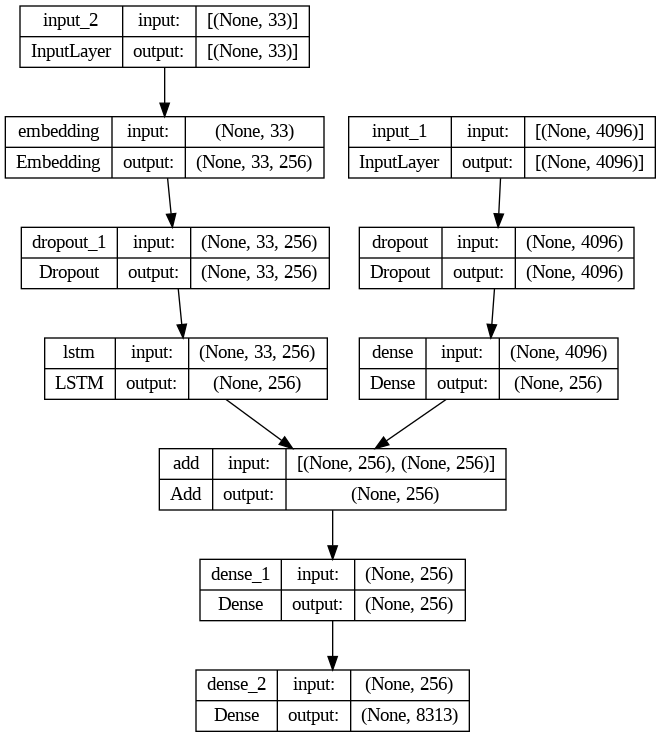

In [ ]:
#encoder model
#image feature layers
inputs1 = Input(shape = (4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

#decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation="softmax")(decoder2)

model = Model(inputs = [inputs1, inputs2], outputs= outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

#plot the model
plot_model(model, show_shapes=True)

Train the model

In [ ]:
epochs = 10
batch_size = 20
steps =len(train) // batch_size

for i in range(epochs):
  generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
  #fit for one epoch
  model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Save the model

In [ ]:
model.save('/content/best_model.h5')

#Generate Captions for images

In [ ]:
def idx_to_word(integer, tokenizer):
  for word, index in tokenizer.word_index_items():
    if index == integer:
      return word
  return None
  

In [ ]:
# generate options for an image
def predict_caption(model, image, tokenizer, max_length):
  #add start tag for generation process
  in_text = "startseq"
  #iterate over the max_length of sequence
  for i in range(max_length):
    #encode input sequence
    sequence = tokenizer.texts_to_sequence([in_text])[0]
    #pad the sequence
    sequence = pad_sequences([sequence], max_length)
    #predict next word
    yhat = model.predict([image, sequence], verbose=0)
    #get index with high probability
    yhat = np.argmax(yhat)
    #convert index to word
    word = idx_to_word(yhat, tokenizer)
    #stop if word not found
    if word is None:
      break
    #append word as Input for generating next word
    in_text += " " + word
    #stop when reach end tag
    if word == "endseq":
      break
  return in_text


validate with test data

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for key in tqdm(test):
  # get actual caption
  captions = mapping[key]
  # predict the caption for image
  y_pred = predict_caption(model, features[key], tokenizer, max_length)

  # split into words
  actual_captions = [caption.split() for caption in captions]
  y_pred = y_pred.split()
  #append to the list
  actual.append(actual_captions)
  predicted.append(y_pred)

#calculate BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0,0,0,0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5,0.5,0,0)))


Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name): 
  #load the image
  image_id = image_name.split('.')[0]
  img_path = "/content/Images/" + image_name
  image = Image.open(img_path)
  captions = mapping[image_id]
  print('-----------------Actual------------------')
  for caption in captions:
    print(caption)
  #predict the caption
  # y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
  # print('-----------------Predicted----------------')
  # print(y_pred)
  plt.imshow(image)


-----------------Actual------------------
<start> black and white dog jumping in the air to get toy <end>
<start> black and white dog jumps up towards yellow toy <end>
<start> dog leaps to catch ball in field <end>
<start> white dog is trying to catch ball in midair over grassy field <end>
<start> the white dog is playing in green field with yellow toy <end>


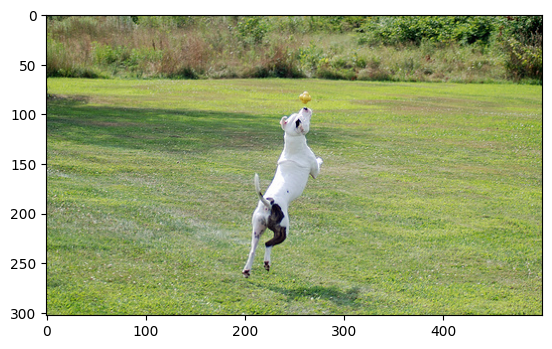

In [ ]:
generate_caption('1020651753_06077ec457.jpg')